# Graph Neural Network Prediction

In [207]:
from rdkit import Chem
from rdkit.Chem import rdmolops
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [208]:
data_df = pd.read_csv('/Users/mohanyang/Documents/GitHub/pIC50_prediction_book/pIC50_prediction/notebooks/gnn_dataset.csv')

In [209]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    adjacency_matrix = rdmolops.GetAdjacencyMatrix(mol)

    # Extract atom-level features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_feature = [
            atom.GetAtomicNum(),  # Atomic number
            atom.GetDegree(),     # Atom degree (number of bonds)
            atom.GetFormalCharge(),  # Formal charge
            atom.GetTotalNumHs(),  # Number of hydrogens
            atom.GetIsAromatic()   # Whether the atom is aromatic
        ]
        atom_features.append(atom_feature)

    atom_features = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.nonzero(torch.tensor(adjacency_matrix), as_tuple=False).t().contiguous()

    return Data(x=atom_features, edge_index=edge_index)

In [210]:
class SMILESDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        # This should return the number of entries in the dataset
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the SMILES string and pIC50 value
        smiles = self.dataframe.iloc[idx, 0]
        pIC50 = self.dataframe.iloc[idx, 1]
        
        # Convert SMILES to graph
        graph_data = smiles_to_graph(smiles)
        
        if graph_data is None:
        # Handle invalid SMILES here
        # Optionally return a dummy graph if needed
            return Data(x=torch.tensor([[0]], dtype=torch.float), edge_index=torch.tensor([[0], [0]], dtype=torch.long), y=torch.tensor([pIC50], dtype=torch.float))
    
        # Add target value (pIC50) as y
        graph_data.y = torch.tensor([pIC50], dtype=torch.float)
        
        return graph_data

In [211]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = torch.nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)  # Dropout after first GCN layer
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)  # Dropout after second GCN layer
        x = F.relu(self.conv3(x, edge_index))

        
        x = global_mean_pool(x, batch)

        # Pass through the first fully connected layer
        x = F.relu(self.fc1(x))  # Apply ReLU to the first fully connected layer
        
        # Apply dropout after first fully connected layer
        x = self.dropout(x)

        # Pass through the second fully connected layer for final output
        x = self.fc2(x) 
        return x

# Define the model
model = GCN(input_dim=5, hidden_dim=1024, output_dim=1)

In [212]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

def train(model, data_loader, epochs=1000):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in data_loader:
            optimizer.zero_grad()
            output = model(data)  # The batch of graphs is passed directly to the model
            
            target = data.y.view(-1, 1)
            
            loss = criterion(output, target)  # data.y is the pIC50 value for each graph
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data_loader)}")

In [213]:
dataset = SMILESDataset(data_df)

valid_data = [data for data in dataset if data is not None]
train_data, test_data = train_test_split(valid_data, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [214]:
train(model, train_loader)

Epoch 1, Loss: 6.2813105218940315
Epoch 2, Loss: 1.7855551077259912
Epoch 3, Loss: 1.6401326308647792
Epoch 4, Loss: 1.7408178100983303
Epoch 5, Loss: 1.676084993614091
Epoch 6, Loss: 1.4965999739037619
Epoch 7, Loss: 1.6290382395188014
Epoch 8, Loss: 1.4959190520975325
Epoch 9, Loss: 1.6659584724240832
Epoch 10, Loss: 1.5021615508529875
Epoch 11, Loss: 1.4114513595898945
Epoch 12, Loss: 1.3948957439925935
Epoch 13, Loss: 1.487552700771226
Epoch 14, Loss: 1.5919769091738596
Epoch 15, Loss: 1.655004580815633
Epoch 16, Loss: 1.4986051668723424
Epoch 17, Loss: 1.4843843198484845
Epoch 18, Loss: 1.5522018820047379
Epoch 19, Loss: 1.3788027183877096
Epoch 20, Loss: 1.624875591860877
Epoch 21, Loss: 1.4447987642553117
Epoch 22, Loss: 1.4518502685758803
Epoch 23, Loss: 1.5872772021426096
Epoch 24, Loss: 1.460867814719677
Epoch 25, Loss: 1.4341921789778604
Epoch 26, Loss: 1.4172320912281673
Epoch 27, Loss: 1.501085079378552
Epoch 28, Loss: 1.3901827947960959
Epoch 29, Loss: 1.405233698586623
E

In [215]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    actuals = []
    predictions = []
    
    with torch.no_grad():  # Disable gradient calculation
        for data in test_loader:
            output = model(data)
            target = data.y.view(-1, 1)
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # Store actual and predicted values for later use
            actuals.extend(data.y.cpu().numpy())
            predictions.extend(output.cpu().numpy())
    
    # Calculate MAE
    mae = mean_absolute_error(actuals, predictions)
    return total_loss / len(test_loader), mae, actuals, predictions

# Assuming you have a DataLoader for the test set
vloss, mae, y_test, y_pred = evaluate_model(model, test_loader)
print(f'Test Mean Absolute Error: {mae}')

Test Mean Absolute Error: 0.4875187277793884


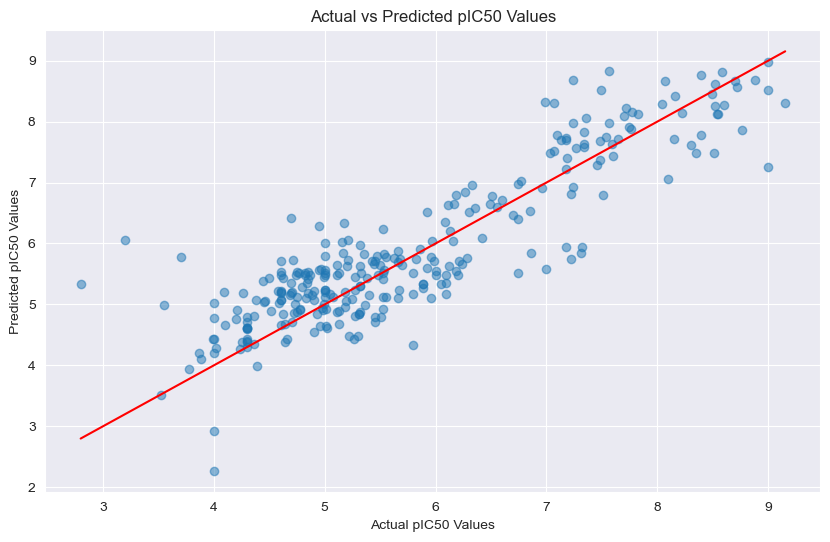

In [216]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual pIC50 Values')
plt.ylabel('Predicted pIC50 Values')
plt.title('Actual vs Predicted pIC50 Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of equality
plt.show()

In [217]:
# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

R² Score: 0.774853582051455
